In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(keras.__version__)
tf.__version__

2.5.0


'2.5.0'

# Descripción del dataset
Este dataset cuenta con 60.000 imágenes de artículos para training y 10.000 imágenes para test. Las imágenes están conformadas por 28x28 píxeles en escala de grises (784 píxeles en total), asociados a un target de 10 clases. Además, es un dataset balanceado, ya que todas las clases poseen el mismo número de imágenes (6000). Este dataset ya viene incorporado en keras.datasets.
El primer paso sería importar los datos y separarlos en train y test. Procede de la siguiente forma:

In [3]:
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
len(y_train)
len(y_test)

4431872/4422102 [==============================] - 0s 0us/step


10000

Visualización de varias imágenes incluidas en los datos

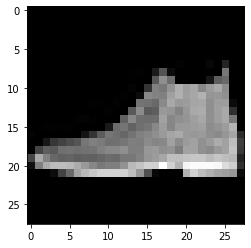

In [4]:
import matplotlib.pyplot as plt
 
plt.imshow(x_test[0:5], cmap="gray")
plt.show()

Continuamos con el preprocesado de los datos antes de la construcción del modelo. Al tener una imagen de 28x28, se traduce en una matriz de 28x28 con 3 canales de colores distintos (RGB). Por ello, cambiamos el formato para mantener todos los píxeles con las mismas dimensiones, pero un solo canal de color.
Como la entrada, además, está comprendida en un rango de 0-255 (modelo RGB para visualizar el color de la imagen, en este caso, comprendida en escala de grises). Vamos a normalizar este valor para cambiar su escala al rango de [0-1]
Al contar con un problema de clasificación multiclase, utilizamos la técnica One Hot Encoding. Este es un proceso mediante el cual las variables categóricas se convierten para que los algoritmos de ML hagan un mejor trabajo en la predicción. Este método nos devuelve una matriz en la que cada elemento es un vector de longitud 10 donde todas las entradas están a 0 excepto la entrada correspondiente a su clase.

In [5]:
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
 
x_train = x_train.astype('float32') / 255 
x_test = x_test.astype('float32') / 255

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)


Por último, vamos a separar el conjunto de entrenamiento para obtener un conjunto de datos de validación. 
La evaluación de cómo de bueno es un modelo en el conjunto de datos de entrenamiento daría como resultado una puntuación sesgada. Por lo tanto, el modelo se evalúa en la muestra de validación para dar una estimación no sesgada de la habilidad del modelo. Esto evita el overfitting y crea generalización.


In [9]:
# barajamos el dataset
permutation = np.random.permutation(x_train.shape[0])
x_train = x_train[permutation]
y_train = y_train[permutation]
 
# obtenemos el conjunto de validación
num_val = 10000
x_val = x_train[:num_val]
x_train = x_train[num_val:]
y_val = y_train[:num_val]
y_train = y_train[num_val:]

# Elaboración del modelo

Introducimos dos redes convolucionales consecutivas de 32 y 64 filtros convolucionales respectivamente de tamaño 3x3, ambas con función de activación relu (función no-lineal muy usada para modelos de Deep Learning que permite acelerar el cómputo en estas capas). Al tratarse de un problema de clasificación de imágenes, introducir este tipo de redes benefician a la extracción de características, ya que permite ver una misma imagen de n formas diferentes, siendo n el número de filtros. Esto se verá reflejado en un aumento del accuracy frente a redes no convolucionales (quedará demostrado posteriormente). 
Al haber introducido la operación de convolución, para que el número de parámetros del sistema no aumente considerablemente, incorporamos la función max pool, que se quedará con el mayor valor de cada una de las áreas de las imágenes convolucionadas, reduciendo así su dimensionalidad.

Como fase final de la construcción del modelo, para la correcta clasificación de las imágenes añadimos 3 capas más: dos capas intermedias de 256 y 128 neuronas, terminando con una última capa de igual número de neuronas al número de clases, 10 para este problema. Las funciones de activación elegidas han sido ‘relu’ para la capa de entrada e intermedias y la función sigmoide para la capa de salida, la cual determina el Target.
Además, añadimos una característica más, dropout. Esto evitará el sobre-entrenamiento eliminando aleatoriamente neuronas al introducir cada patrón distinto. Así, conseguimos que las neuronas individuales no se especialicen en características concretas, aumentando la generalización del modelo. Introducimos esto entre las capas para que establezca aleatoriamente las unidades de entrada a 0 con una frecuencia de 0.25 en cada paso durante el tiempo de entrenamiento.

In [10]:
np.random.seed(1234)

model = keras.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(keras.layers.Dense(256, activation= "relu")) 
model.add(Dropout(0.25))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(keras.layers.Dense(10, activation='sigmoid'))


# Compilación del modelo

Para la compilación, vamos a usar un tipo de optimizador basado en el descenso del gradiente llamado RMSprop, un algoritmo incorporado en Keras que combina la robustez del algoritmo original Rprop con la eficiencia de trabajar por lotes. La idea es que, en lugar de mantener un acumulado de los gradientes, se utiliza el concepto de "ventana" para considerar solo los gradientes más recientes. 
El valor loss es el parámetro de selección de función de pérdida. Esta se utiliza para calcular los gradientes, y estos para actualizar los pesos de la red. Al ser un problema con datos categóricos, la función a elegir será la incorporada en Keras como Categorical Crossentropy (CC).
El entrenamiento se hará por lotes de tamaño 128 y durante 30 épocas.


In [11]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
train_log = model.fit(x_train, y_train, epochs=30, batch_size=128, validation_data=(x_val, y_val))

Epoch 1/30
391/391 [==============================] - 148s 338ms/step - loss: 0.8039 - accuracy: 0.7158 - val_loss: 0.3330 - val_accuracy: 0.8762
Epoch 2/30
391/391 [==============================] - 132s 338ms/step - loss: 0.3194 - accuracy: 0.8846 - val_loss: 0.2812 - val_accuracy: 0.8957
Epoch 3/30
391/391 [==============================] - 132s 337ms/step - loss: 0.2571 - accuracy: 0.9090 - val_loss: 0.2581 - val_accuracy: 0.9053
Epoch 4/30
391/391 [==============================] - 132s 337ms/step - loss: 0.2171 - accuracy: 0.9215 - val_loss: 0.2275 - val_accuracy: 0.9152
Epoch 5/30
391/391 [==============================] - 131s 335ms/step - loss: 0.1961 - accuracy: 0.9301 - val_loss: 0.2292 - val_accuracy: 0.9179
Epoch 6/30
391/391 [==============================] - 132s 337ms/step - loss: 0.1718 - accuracy: 0.9395 - val_loss: 0.2425 - val_accuracy: 0.9174
Epoch 7/30
391/391 [==============================] - 131s 335ms/step - loss: 0.1575 - accuracy: 0.9435 - val_loss: 0.2413 -

# Resultados y conclusiones


Finalizado el entrenamiento, podemos probar el modelo contra el conjunto de prueba y obtener la exactitud de nuestro modelo resultante.

In [12]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(test_accuracy)

313/313 [==============================] - 7s 23ms/step - loss: 0.3863 - accuracy: 0.9197
0.919700026512146


El accuracy obtenido es de 0.9197 (97.97%). Vamos a graficar el histórico con los valores que ha ido tomando la función de coste y la precisión tanto del conjunto de entrenamiento como del de validación.

## Gráfica de la función de coste

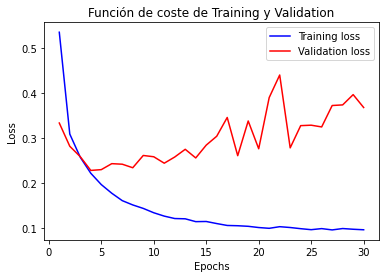

In [15]:
loss = train_log.history['loss']
val_loss = train_log.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Función de coste de Training y Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Gráfica de la función de exactitud

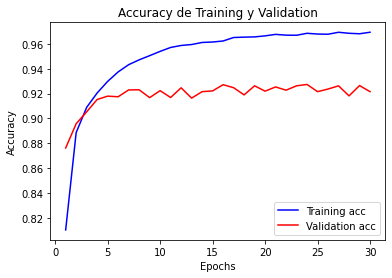

In [16]:
plt.clf()
acc = train_log.history['accuracy']
val_acc = train_log.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy de Training y Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

De las dos gráficas anteriores, podemos concluir que existe un sobre-entrenamiento gracias a visualizar la función del conjunto de validación junto a la de entrenamiento, ya que mientras que el conjunto de Training desciende de forma continua durante todas las épocas (Función de coste), el conjunto de Validation empieza a ascender incluso antes de la quinta época. Esto quiere decir que para el conjunto de entrenamiento funciona cada vez mejor, pero al presentar un nuevo conjunto no visto antes, el modelo no es tan bueno e indica que no es un modelo con mucha generalización. 
Para solucionar esto, vamos a volver a entrenar el modelo hasta la etapa número 5, ya que es donde empieza a verse el punto de inflexión de Validation.


In [18]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
train_log = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_val, y_val))

Epoch 1/5
391/391 [==============================] - 142s 359ms/step - loss: 0.1088 - accuracy: 0.9660 - val_loss: 0.2927 - val_accuracy: 0.9093
Epoch 2/5
391/391 [==============================] - 140s 359ms/step - loss: 0.0903 - accuracy: 0.9711 - val_loss: 0.3333 - val_accuracy: 0.9232
Epoch 3/5
391/391 [==============================] - 141s 360ms/step - loss: 0.0906 - accuracy: 0.9714 - val_loss: 0.2916 - val_accuracy: 0.9169
Epoch 4/5
391/391 [==============================] - 141s 360ms/step - loss: 0.0958 - accuracy: 0.9704 - val_loss: 0.2802 - val_accuracy: 0.9182
Epoch 5/5
391/391 [==============================] - 138s 353ms/step - loss: 0.0946 - accuracy: 0.9687 - val_loss: 0.3523 - val_accuracy: 0.9231


In [21]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(test_accuracy)

313/313 [==============================] - 8s 24ms/step - loss: 0.3909 - accuracy: 0.9227
0.9226999878883362


Con este nuevo entrenamiento, se consigue un Accuracy con los datos de Test de 0.9227 (92.27%), aumentando un 0.3% y ganando mucho tiempo de cómputo al haber reducido 6 veces el número de épocas. 
Por lo tanto, evitar que la red se sobre-ajuste a los datos beneficia a en la predicción y en el coste computacional.


Para terminar, vamos a comprobar cuánto se gana al introducir redes convolucionales en un problema de este tipo. Para ello, generamos un nuevo modelo con una arquitectura distinta. 
Primero, vamos a convertir los datos de entrada a un solo vector de 784, ya que la imagen es de 28x28. 



In [28]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.reshape((60000, 784))
x_train = x_train.astype('float32') / 255
y_train = tf.keras.utils.to_categorical(y_train)
 
x_test = x_test.reshape((10000, 784))
x_test = x_test.astype('float32') / 255
y_test = tf.keras.utils.to_categorical(y_test)

# barajamos el dataset
permutation = np.random.permutation(x_train.shape[0])
x_train = x_train[permutation]
y_train = y_train[permutation]
 
# obtenemos el conjunto de validación
num_val = 10000
x_val = x_train[:num_val]
x_train = x_train[num_val:]
y_val = y_train[:num_val]
y_train = y_train[num_val:]

Con los datos dispuestos de esta forma, entrenaremos una red compuesta únicamente de 4 capas: capa de entrada formada por 784 neuronas (número de entradas), 2 capas intermedias 256 y 128 neuronas respectivamente y la capa de salida con 10 neuronas, como en la arquitectura anterior. 

In [29]:
model = keras.Sequential()

model.add(keras.layers.Dense(256, input_shape=(784,), activation= "relu")) 
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(10, activation='sigmoid'))

model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
train_log = model.fit(x_train, y_train, epochs=30, batch_size=128, validation_data=(x_val, y_val))

Epoch 1/30
391/391 [==============================] - 4s 9ms/step - loss: 0.7640 - accuracy: 0.7295 - val_loss: 0.4039 - val_accuracy: 0.8550
Epoch 2/30
391/391 [==============================] - 3s 8ms/step - loss: 0.3987 - accuracy: 0.8544 - val_loss: 0.3756 - val_accuracy: 0.8593
Epoch 3/30
391/391 [==============================] - 3s 8ms/step - loss: 0.3453 - accuracy: 0.8729 - val_loss: 0.3720 - val_accuracy: 0.8659
Epoch 4/30
391/391 [==============================] - 3s 8ms/step - loss: 0.3172 - accuracy: 0.8847 - val_loss: 0.3859 - val_accuracy: 0.8605
Epoch 5/30
391/391 [==============================] - 3s 9ms/step - loss: 0.2978 - accuracy: 0.8906 - val_loss: 0.3613 - val_accuracy: 0.8685
Epoch 6/30
391/391 [==============================] - 3s 9ms/step - loss: 0.2813 - accuracy: 0.8950 - val_loss: 0.3546 - val_accuracy: 0.8658
Epoch 7/30
391/391 [==============================] - 3s 8ms/step - loss: 0.2643 - accuracy: 0.9012 - val_loss: 0.3691 - val_accuracy: 0.8655
Epoch 

In [30]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.5763 - accuracy: 0.8810


Tras el entrenamiento, obtenemos un accuracy del 88.1%, aunque el tiempo de entrenamiento ha sido mucho menor. 
Se puede concluir tras esto que las redes convolucionales Deep Learning obtienen mejores resultados para predicción de imágenes, ya que cuenta con la etapa extra de extracción de características, haciendo que la red acabe reconociendo con más exactitud patrones no conocidos previamente.
